In [9]:
# TODO #1207 - badges

based on [Rozanski & Sonntag 1982](https://doi.org/10.3402/tellusa.v34i2.10795) with the following differences:
- integration over altitude instead of temperature
- extended to cover also oxygen-18

In [1]:
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot
from PySDM.physics import si, in_unit
from PySDM import Formulae
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line_excess='Dansgaard1964',
    isotope_ratio_evolution='MerlivatAndJouzel1979'
)
const = formulae.constants

FIG4_CAPTION = {
    'T_init': const.T0 + 25 * si.K,
    'T_fini': const.T0 - 10 * si.K,
    'T_step': 2 * si.K,
    'P_init': 1000 * si.mbar,
    'RH_init': 80 * const.PER_CENT,
    'delta_2H_init': -74.7 * const.PER_MILLE,  # note: R0 in the caption, but negative, hence delta
    'isotope_exchange_factor': 1,  # K
    'autoconversion_density_threshold': 1 * si.g / si.m**3  # N_L, note: mixing ratio in the caption, but per-volume units, hence density
}

In [3]:
N = 5
ix_T = 0
ix_qv = 1
ix_ql = 2
ix_R_2H = 3
ix_R_18O = 4

step_T = FIG4_CAPTION['T_step']

y0 = np.empty(N)
y0[ix_T] = FIG4_CAPTION['T_init']
y0[ix_qv] = 10 * si.g / si.kg       # TODO !!! (derive from RH, p, T)
y0[ix_ql] = 0
y0[ix_R_2H] = formulae.trivia.isotopic_delta_2_ratio(
    delta=FIG4_CAPTION['delta_2H_init'],
    reference_ratio=const.VSMOW_R_2H
)
y0[ix_R_18O] = formulae.trivia.isotopic_delta_2_ratio(
    delta=formulae.isotope_meteoric_water_line_excess.d18O_of_d2H(
        delta_2H=FIG4_CAPTION['delta_2H_init']
    ),
    reference_ratio=const.VSMOW_R_18O
)

alphas = {
    ix_R_2H: formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H,
    ix_R_18O: formulae.isotope_equilibrium_fractionation_factors.alpha_l_18O,
}

def dy_dz_fun(_, y):
    dy_dz = np.zeros(N)
    dy_dz[ix_T] = -6.5 * si.K / si.km  # TODO #1063: arbitrary value!
    dy_dz[ix_ql] = 2 * si.g / si.kg / si.km  # TODO #1063: arbitrary value!
    dy_dz[ix_qv] = - dy_dz[ix_ql]

    for iso in (ix_R_2H, ix_R_18O):
        alpha = alphas[iso]
        T = y[ix_T]
        alpha_at_T = alpha(T)
        dalpha_dT_at_T = (alpha(T + .5 * step_T) - alpha(T - .5 * step_T)) / step_T
        
        dy_dz[iso] = Rv=y[iso] * formulae.isotope_ratio_evolution.d_Rv_over_Rv(
            alpha=alpha_at_T,
            d_alpha=dalpha_dT_at_T * dy_dz[ix_T],
            n_vapour=y[ix_qv],
            d_n_vapour=dy_dz[ix_qv],
            n_liquid=y[ix_ql]
        )
    return dy_dz
    
z_max = 7000 * si.m    # TODO !!!
integ = solve_ivp(
    fun=dy_dz_fun,
    t_span=(0, z_max),
    y0=y0,
    t_eval=np.linspace(0, z_max, 25)
)
assert integ.success, integ.message

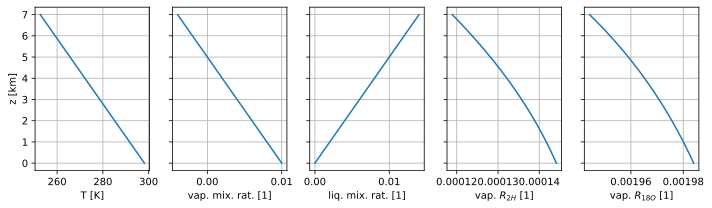

HTML(value="<a href='./model_state.pdf' target='_blank'>./model_state.pdf</a><br>")

In [4]:
fig, axs = pyplot.subplots(1, N, sharey=True, tight_layout=True, figsize=(10, 3))

labels = [""] * N
labels[ix_T] = "T [K]"
labels[ix_qv] = "vap. mix. rat. [1]"
labels[ix_ql] = "liq. mix. rat. [1]"
labels[ix_R_2H] = "vap. $R_{2H}$ [1]"
labels[ix_R_18O] = "vap. $R_{18O}$ [1]"

for i, label in enumerate(labels):
    axs[i].plot(integ.y[i], integ.t / si.km)
    axs[i].set_xlabel(label)

axs[0].set_ylabel("z [km]")
for ax in axs:
    ax.grid()

show_plot('model_state.pdf')

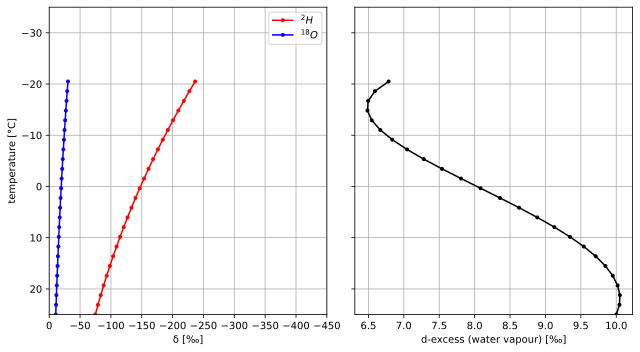

HTML(value="<a href='./fig_4_plus_18O_plus_excess.pdf' target='_blank'>./fig_4_plus_18O_plus_excess.pdf</a><br…

In [5]:
fig, axs = pyplot.subplots(1, 2, sharey=True, tight_layout=True, figsize=(9, 5))
T_C = integ.y[ix_T] - const.T0
delta = {}
for ix_iso in (ix_R_2H, ix_R_18O):
    delta[ix_iso] = formulae.trivia.isotopic_ratio_2_delta(
        ratio=integ.y[ix_iso],
        reference_ratio={
            ix_R_2H: const.VSMOW_R_2H,
            ix_R_18O: const.VSMOW_R_18O
        }[ix_iso]
    )
    axs[0].plot(
        in_unit(delta[ix_iso], const.PER_MILLE),
        T_C,
        marker='.',
        color={ix_R_2H: 'red', ix_R_18O: 'blue'}[ix_iso],
        label={ix_R_2H: '$^2H$', ix_R_18O: '$^{18}O$'}[ix_iso]
    )
axs[0].legend()
axs[0].set_xlabel("δ [‰]")
axs[0].set_ylabel("temperature [°C]")
axs[0].set_xlim(0, -450)
axs[0].set_ylim(25, -35)
axs[0].grid()

axs[1].plot(
    in_unit(
        formulae.isotope_meteoric_water_line_excess.excess_d(delta[ix_R_2H], delta[ix_R_18O]),
        const.PER_MILLE
    ),
    T_C,
    color='black',
    marker='.'
)
axs[1].grid()
axs[1].set_xlabel("d-excess (water vapour) [‰]")
show_plot('fig_4_plus_18O_plus_excess.pdf')